In [27]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import sys
import tensorflow as tf
import tensorflow as tf
# tf.compat.v1.disable_eager_execution()
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.patches import Polygon
import itertools
import os 
from coord import CoordinateChannel2D
from tensorflow.keras import layers
import os
from iou import getIOU
from sklearn.metrics import mean_squared_error
import argparse
import matplotlib.pylab as plt


In [96]:
# parser = argparse.ArgumentParser(description='Process some integers.')
# parser.add_argument('--datadir', dest='dataset_directory', type=str, default='./card_synthetic_dataset', help='if loading a preexisting model')
# parser.add_argument('--modelPath', dest='model_path', type=str, default='./lite_model.tflite', help='if loading a preexisting model')
# parser.add_argument('--noNormalize', dest='normalize', action='store_false',  help='normalizing or not')
# params = parser.parse_args()
#lite_model_quant_DBv2_b64_r16.tflite'#v4_outBox/normalized_albumations_v4.tflite'

model_path = 'models/lite_model_quant_DBv2_b64_r16.tflite'
# model_path = 'models/v4_outBox/normalized_albumations_v4.tflite'

dataset_directory = './datasets/videoData'
target_size = (1080, 1920)
crop = 1
normalize = False

# crop = 0
# dataset_directory = './datasets/card_dataset_dummy_v4'
# target_size = (image_wh, image_wh)
# normalize = True


In [97]:
lst = [x[0].split('/')[-1] for x in os.walk(dataset_directory)]
if 'train' in lst:
  dataset_directory += '/test'

df = pd.read_csv(os.path.join(dataset_directory, 'labels.csv'), header='infer')
df.drop(columns=['glare', 'fld_mask', 'punch'], inplace=True)

labels = list(df)[1:]
filenames = list(df)[0]

if normalize:
  factor = 1.0/255
else:
  factor = 1.0
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(featurewise_center=False, rescale=factor, horizontal_flip=False, vertical_flip=False)

image_wh = 224
train_len = len(df) // 2
valid_len = len(df) * 3 // 4
seed = 1

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)


test_generator = test_datagen.flow_from_dataframe(
    dataframe=df,
    directory=dataset_directory,
    x_col=filenames,
    y_col=labels,
    batch_size=1,
    seed=seed,
    shuffle=False,
    class_mode="other",
    target_size=target_size)

ious = []
results = []
labels = []
mse = []
rms = []

Found 46 validated image filenames.


(1, 1080, 1080, 3)


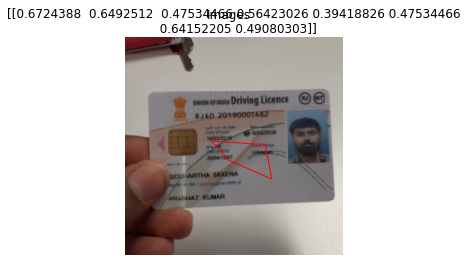

(1, 1080, 1080, 3)


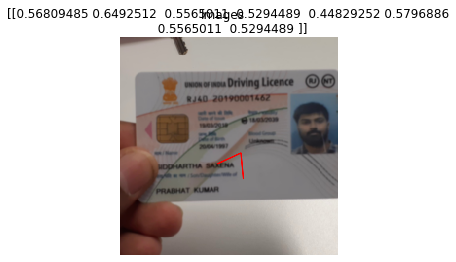

(1, 1080, 1080, 3)


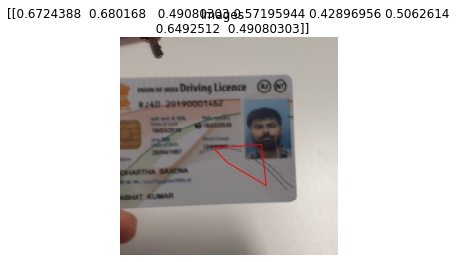

(1, 1080, 1080, 3)


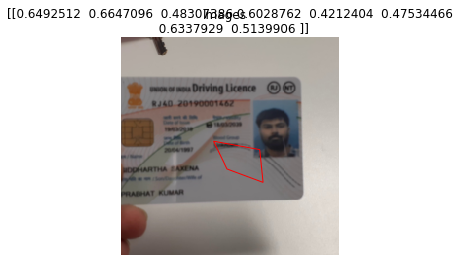

(1, 1080, 1080, 3)


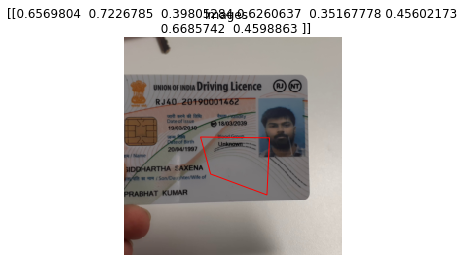

(1, 1080, 1080, 3)


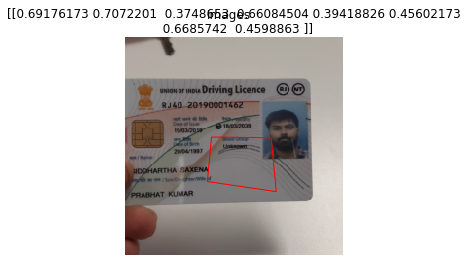

(1, 1080, 1080, 3)


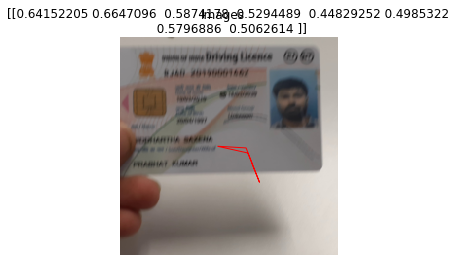

(1, 1080, 1080, 3)


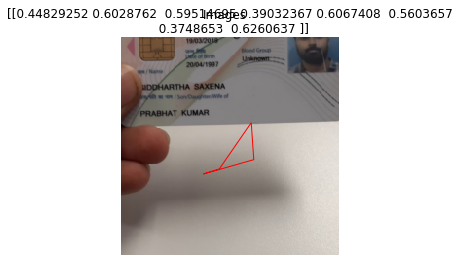

(1, 1080, 1080, 3)


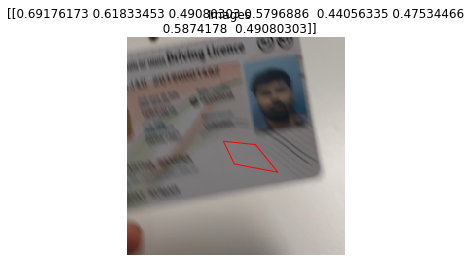

(1, 1080, 1080, 3)


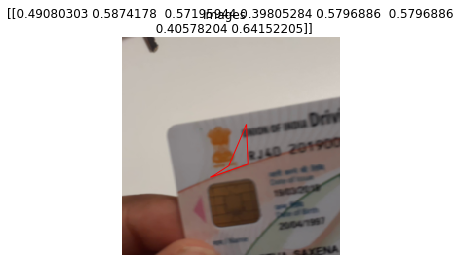

(1, 1080, 1080, 3)


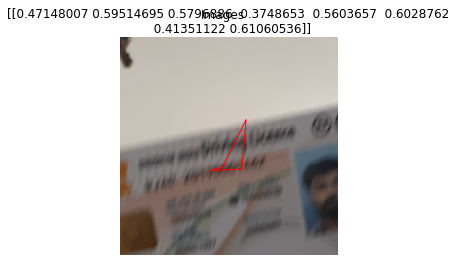

(1, 1080, 1080, 3)


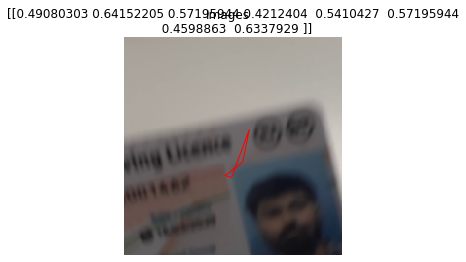

(1, 1080, 1080, 3)


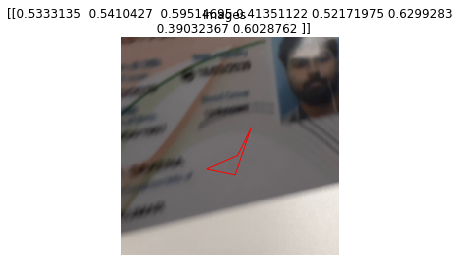

(1, 1080, 1080, 3)


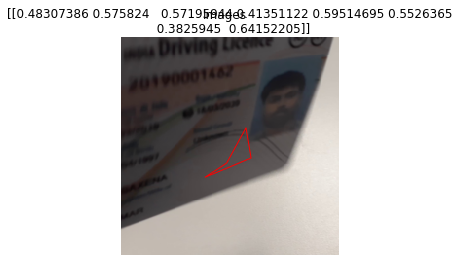

(1, 1080, 1080, 3)


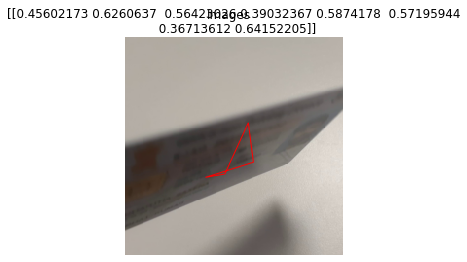

(1, 1080, 1080, 3)


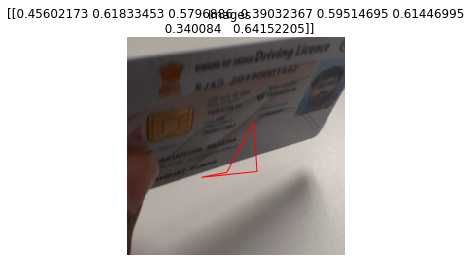

(1, 1080, 1080, 3)


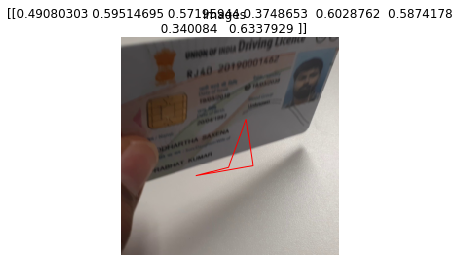

(1, 1080, 1080, 3)


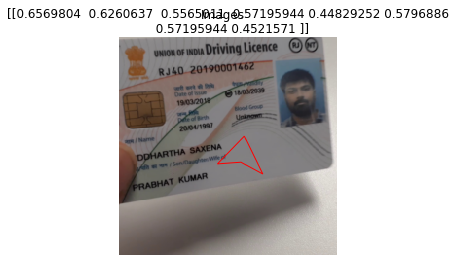

(1, 1080, 1080, 3)


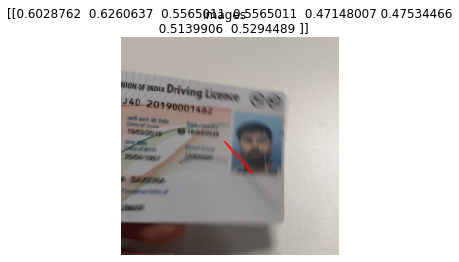

(1, 1080, 1080, 3)


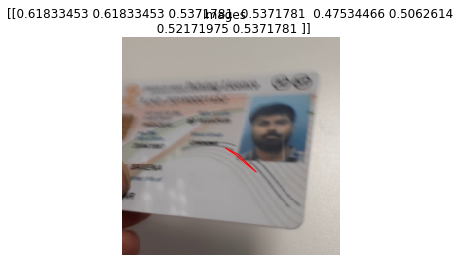

(1, 1080, 1080, 3)


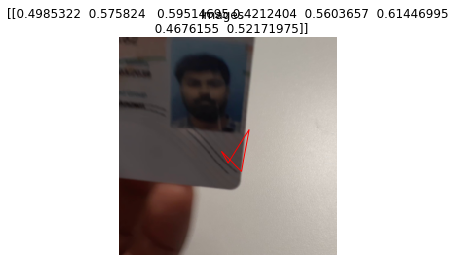

(1, 1080, 1080, 3)


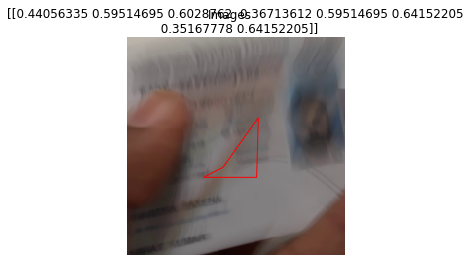

(1, 1080, 1080, 3)


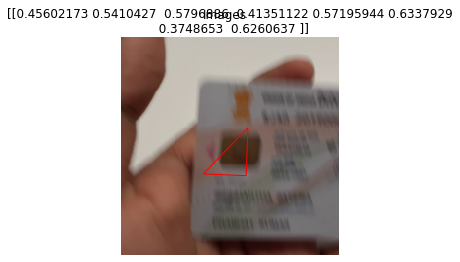

(1, 1080, 1080, 3)


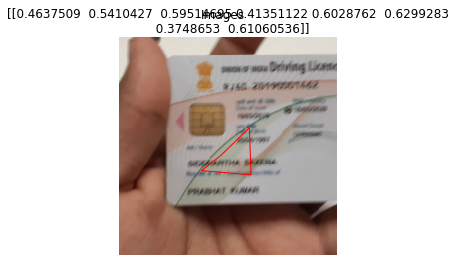

(1, 1080, 1080, 3)


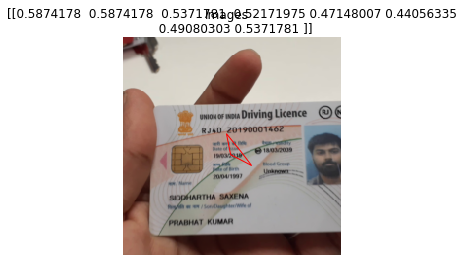

(1, 1080, 1080, 3)


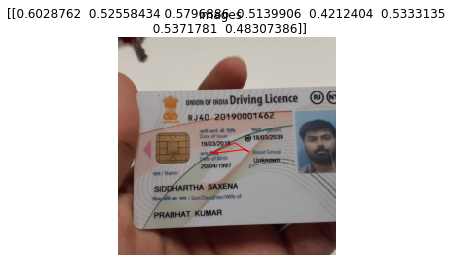

(1, 1080, 1080, 3)


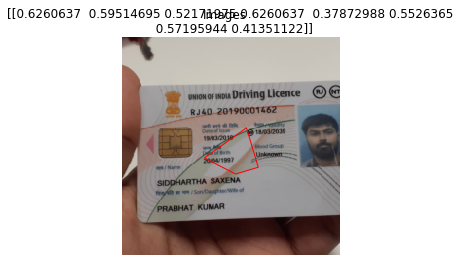

(1, 1080, 1080, 3)


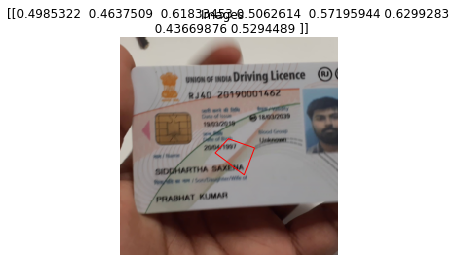

(1, 1080, 1080, 3)


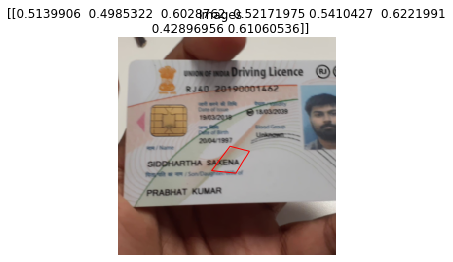

(1, 1080, 1080, 3)


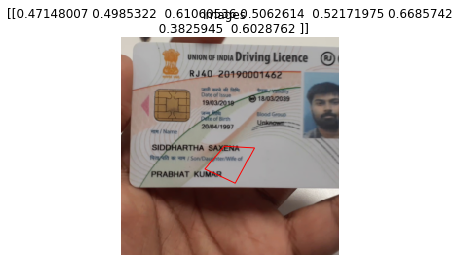

(1, 1080, 1080, 3)


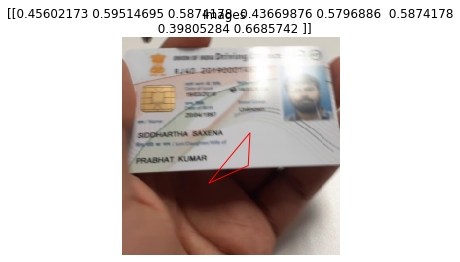

(1, 1080, 1080, 3)


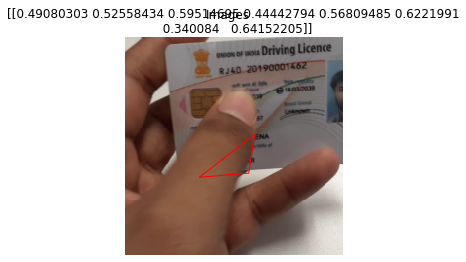

(1, 1080, 1080, 3)


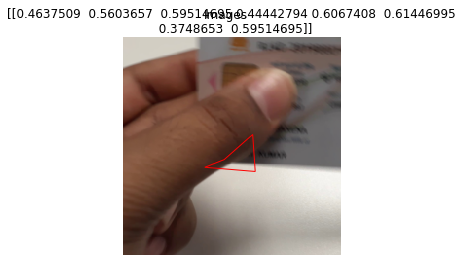

(1, 1080, 1080, 3)


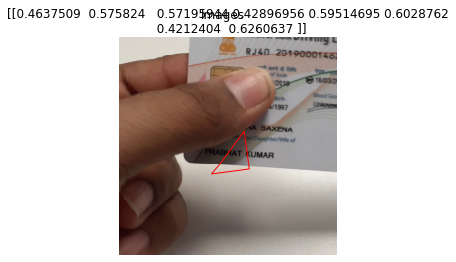

(1, 1080, 1080, 3)


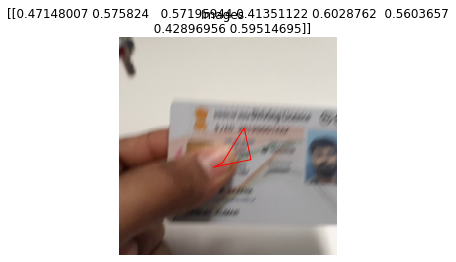

(1, 1080, 1080, 3)


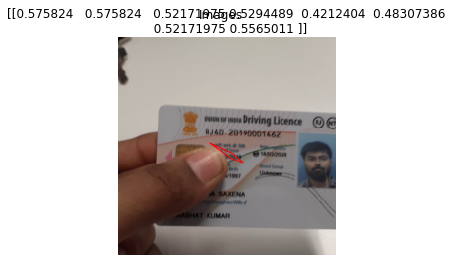

(1, 1080, 1080, 3)


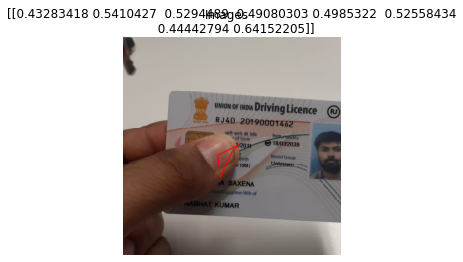

(1, 1080, 1080, 3)


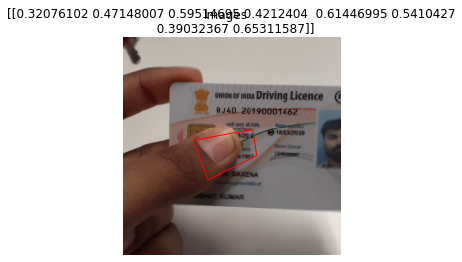

(1, 1080, 1080, 3)


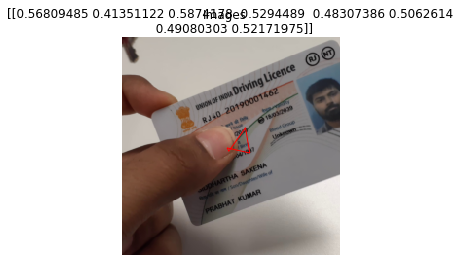

(1, 1080, 1080, 3)


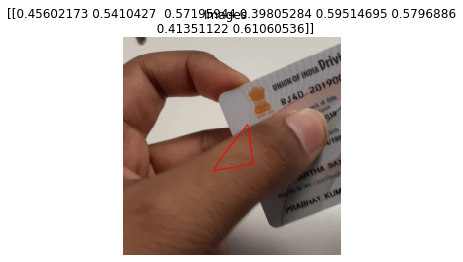

In [98]:
# for i in range(len(test_generator)):
import cv2
import scipy
from skimage.transform import resize
#     if i % 100 == 0:
#       print(i)
for i in range(40):
    input_data = next(test_generator)
    # here input data is dummy dataset of same shape as input data
    data, label = input_data
    if crop:
        data = data[:, :, 420:-420]#.transpose((1, 2, 0))
        print(data.shape)
        data = resize(data, (1, image_wh, image_wh, 3))

    labels.append(label)
    interpreter.set_tensor(input_details[0]['index'], data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])

    if normalize is False:
        data = data/255
    
    plt.imshow(data[0])
    plt.title(output_data[:2]) # Top Left corner only
    plg = np.reshape(output_data*data.shape[1], (-1, 2))
    plt.gca().add_patch(Polygon(plg, ec='r', fc='none'))
    plt.axis('off')
    _ = plt.suptitle("Images")
    plt.show()
